# Figure for Multiprogramming paper

## Initialization

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
from qiskit_aer.noise import NoiseModel
from datetime import datetime
import mysql.connector
import networkx as nx

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

import matplotlib.pyplot as plt
# plt.style.use('tableau-colorblind10')
# font = {'size'   : 16}
# plt.rc('font', **font)

import numpy as np
import pandas as pd
import seaborn as sns
import re

# CB_color_cycle = ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF',
                 
#                  ]

CB_color_cycle = [
    '#006BA4',  # Blue
    '#FF800E',  # Orange
    '#ABABAB',  # Gray
    '#595959',  # Dark Gray
    '#5F9ED1',  # Light Blue
    '#C85200',  # Dark Orange
    '#898989',  # Medium Gray
    '#A2C8EC',  # Pale Blue
    '#FFBC79',  # Light Orange
    '#CFCFCF',  # Light Gray
    '#009E73',  # Green (Colorblind-friendly)
    '#F0E442'   # Yellow (Colorblind-friendly)
]
                  

#1F77B4 0
#FFBB78 3
#2CA02C 4
#98DF8A 5
#D62728 6
#FF9896 7

CB_color_cycle_polar = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

markers = ['o', 'v', 'd', 's', '+', 'x', '^', '*', '<', '>', 'p', '1', '2', '3', '4']
linestyles = ['-', '--', ':', '-.', '-', '--', '-.', ':']

#calibration_sets = ["real", "avg", "recent", "decay_r"]
calibration_sets = ["real", "avg"]
# opts = ["TriQ", "SCR"]
# opts = ["TriQ"]



# MySQL connection parameters
mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'localhost',
    'database': 'framework'
}

mysql_config_online = {
    'user': 'handy',
    'password': 'handy',
    'host': 'ec2-16-171-135-24.eu-north-1.compute.amazonaws.com',
    'database': 'calibration_data'
}





## Calibration Paper Circuits

### Whisker Plot

In [36]:
def get_data_calibration(user_id, circuit_name=None, hw_name=None):
    conn = mysql.connector.connect(**mysql_config)
    cursor = conn.cursor()

    sql = f"""
    SELECT CASE WHEN hw_name IN ("ibm_kyiv", "ibm_sherbrooke", "ibm_brisbane") THEN "Eagle" ELSE "Heron" END as chip_name, 
    hw_name, circuit_name, compilation_name, dd_sequence_type, COALESCE(mp_circuits, 0), 
CONCAT(prune_type, "-" , dd_sequence_type) as prune_type, 
success_rate_tvd, circuit_depth, total_two_qubit_gate FROM (
SELECT hw_name, circuit_name, compilation_name, COALESCE(dd_sequence_type, "no-dd") as dd_sequence_type, mp_circuits, 
COALESCE(prune_type, "no-prune") AS prune_type, 
success_rate_tvd, circuit_depth, total_two_qubit_gate
FROM framework.result WHERE user_id IN ({user_id}) AND status = "done" AND circuit_name != "merged"
"""

    if circuit_name != None:
       sql = sql + f""" AND circuit_name = "{circuit_name}" """
    else:
        sql = sql + f"""AND hw_name = "{hw_name}" """

    sql = sql + """ ) X """

    # insert to circuit
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()

    chip_name = []
    hw_name = []
    circuit_name = []
    compilation_name = []
    dd_sequence_type = []
    mp_circuits = []
    prune_type = []
    success_rate_tvd = []
    circuit_depth = []
    total_two_qubit_gate = []
    
    for res in results:
        _chip_name, _hw_name, _circuit_name, _compilation_name, _dd_sequence_type, _mp_circuits, _prune_type, _success_rate_tvd, _circuit_depth, _total_two_qubit_gate = res
    
        chip_name.append(_chip_name)
        hw_name.append(_hw_name)
        circuit_name.append(_circuit_name)
        compilation_name.append(_compilation_name)
        dd_sequence_type.append(_dd_sequence_type)
        mp_circuits.append(_mp_circuits)
        prune_type.append(_prune_type)
        success_rate_tvd.append(float(_success_rate_tvd))
        circuit_depth.append(float(_circuit_depth))
        total_two_qubit_gate.append(float(_total_two_qubit_gate))

    df = pd.DataFrame({
        'chip_name': chip_name,
        'hw_name': hw_name,
        'circuit_name': circuit_name,
        'compilation_name': compilation_name,
        'dd_sequence_type': dd_sequence_type,
        'mp_circuits': mp_circuits,
        'prune_type': prune_type,
        'success_rate_tvd': success_rate_tvd,
        'circuit_depth': circuit_depth,
        'total_two_qubit_gate': total_two_qubit_gate,
        })

    return df

In [37]:
get_data_calibration("4,6", hw_name="ibm_kyiv")

,chip_name,hw_name,circuit_name,compilation_name,dd_sequence_type,mp_circuits,prune_type,success_rate_tvd,circuit_depth,total_two_qubit_gate
0,Eagle,ibm_kyiv,OR_5,qiskit_3,XpXm,0,no-prune-XpXm,0.43250,229.0,56.0
1,Eagle,ibm_kyiv,hs4,qiskit_3,XpXm,0,no-prune-XpXm,0.89900,12.0,4.0
2,Eagle,ibm_kyiv,AND_5,qiskit_3,XpXm,0,no-prune-XpXm,0.41500,242.0,56.0
3,Eagle,ibm_kyiv,bv4,qiskit_3,XpXm,0,no-prune-XpXm,0.88550,14.0,3.0
4,Eagle,ibm_kyiv,adder_n4,qiskit_3,XpXm,0,no-prune-XpXm,0.87725,44.0,16.0
...,...,...,...,...,...,...,...,...,...,...
856,Eagle,ibm_kyiv,AND_5,qiskit_3,no-dd,0,lf-no-dd,0.09225,358.0,76.0
857,Eagle,ibm_kyiv,bv4,qiskit_3,no-dd,0,lf-no-dd,0.74100,30.0,6.0
858,Eagle,ibm_kyiv,adder_n4,qiskit_3,no-dd,0,lf-no-dd,0.85250,67.0,16.0
859,Eagle,ibm_kyiv,fredkin,qiskit_3,no-dd,0,lf-no-dd,0.80000,97.0,15.0


In [38]:
# "adder_n4", "AND_5", "OR_5", "toffoli_n3", "hs4", "bv4", "fredkin", "merged"

In [39]:
def plot_whisker_cal(user_id, circuit_name=None, hw_name=None):
    df_cal = get_data_calibration(user_id, circuit_name, hw_name)
    
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=df_cal, x="prune_type", y="success_rate_tvd", hue="hw_name")
    
    # Labels and title
    plt.xlabel("Prune Type")
    plt.ylabel("Fidelity")
    plt.title(circuit_name)
    plt.grid(axis="y")
    plt.ylim(0, 1)
    
    # plt.legend(title="Hardware Name")
    plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1), fancybox=False, shadow=True, ncol=1)
    plt.tight_layout()
    plt.show()

#### Without DD

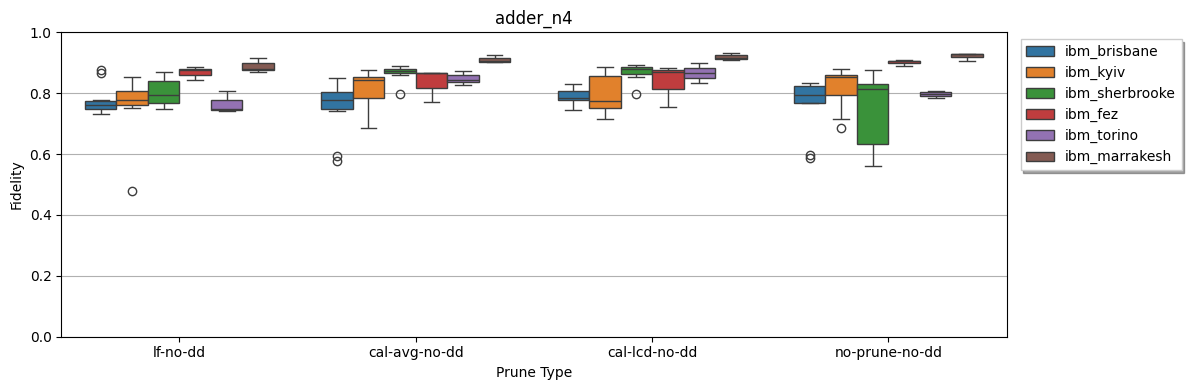

In [40]:
plot_whisker_cal(4, "adder_n4")

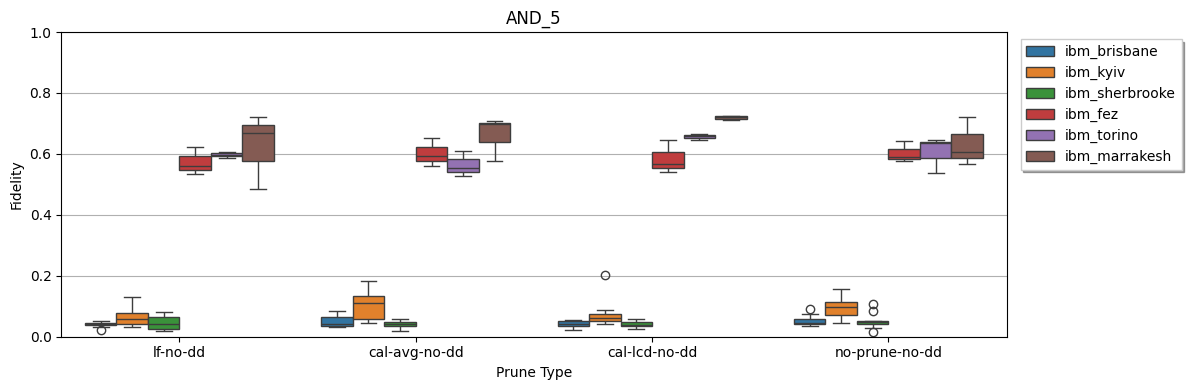

In [41]:
plot_whisker_cal(4, "AND_5", "ibm_kyiv")

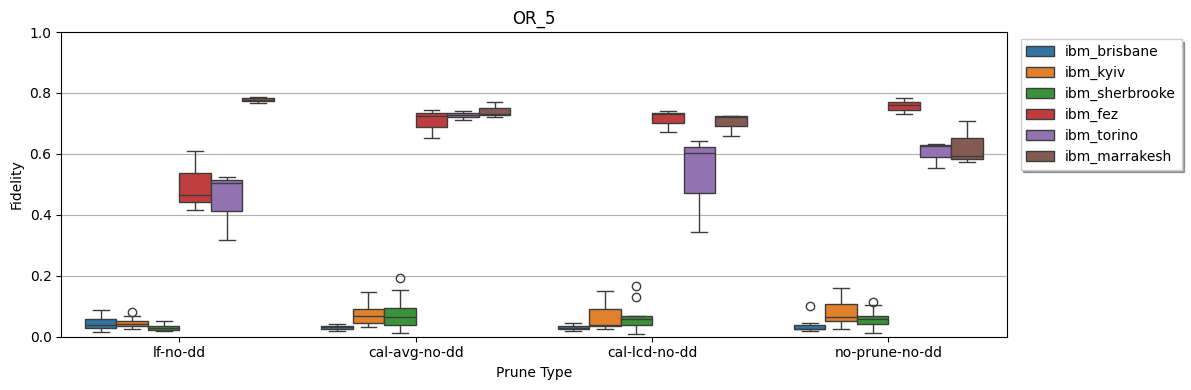

In [42]:
plot_whisker_cal(4, "OR_5", "ibm_kyiv")

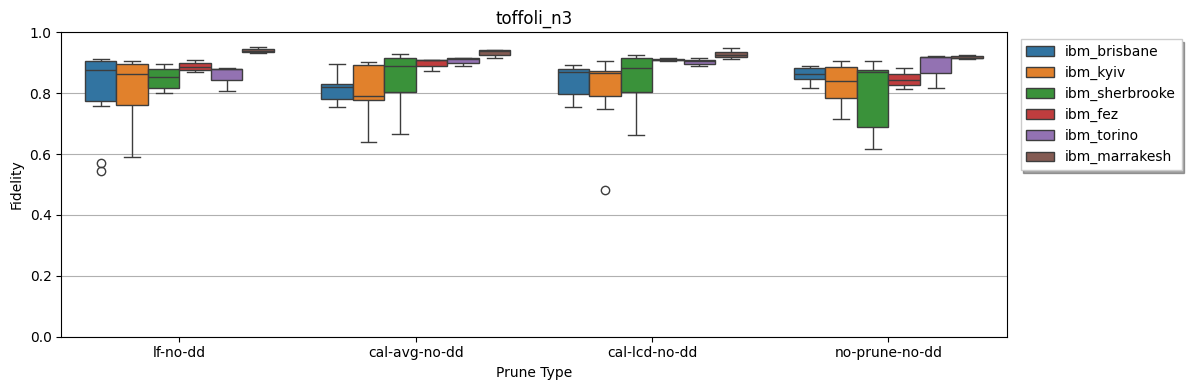

In [43]:
plot_whisker_cal(4, "toffoli_n3", "ibm_kyiv")

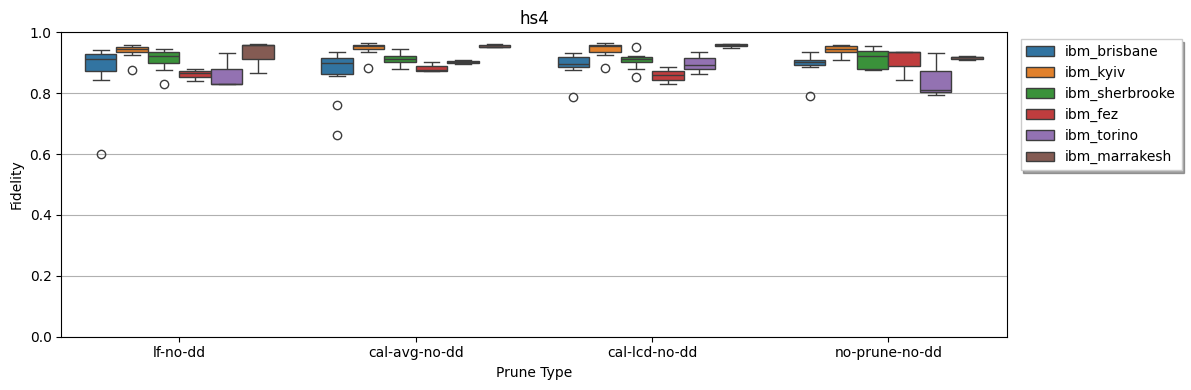

In [44]:
plot_whisker_cal(4, "hs4", "ibm_kyiv")

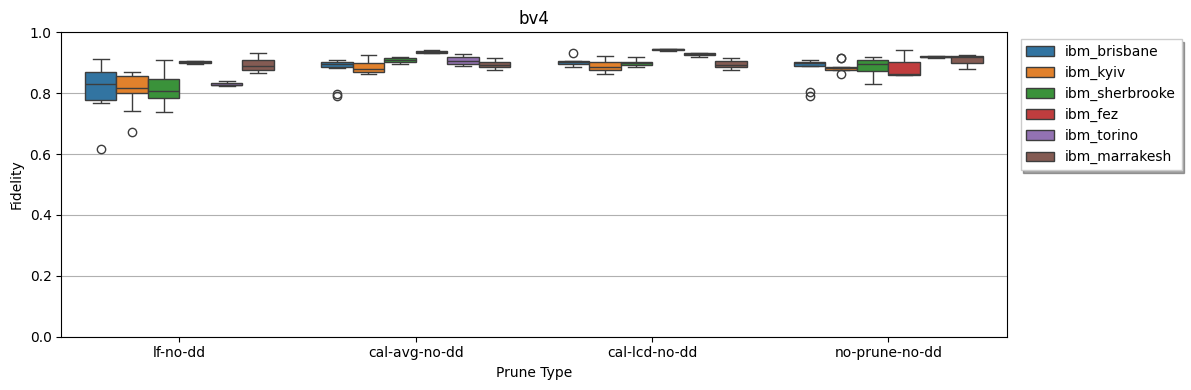

In [45]:
plot_whisker_cal(4, "bv4", "ibm_kyiv")

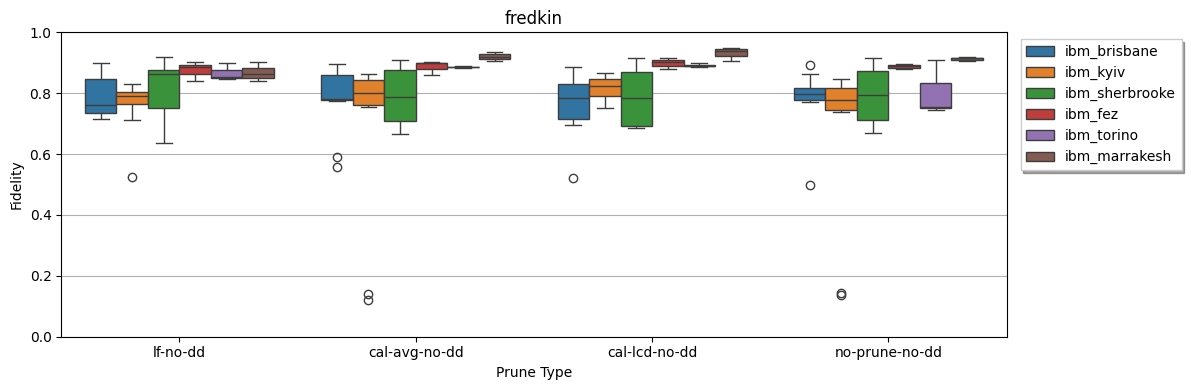

In [46]:
plot_whisker_cal(4, "fredkin", "ibm_kyiv")

/tmp/ipykernel_87386/2352839699.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1), fancybox=False, shadow=True, ncol=1)


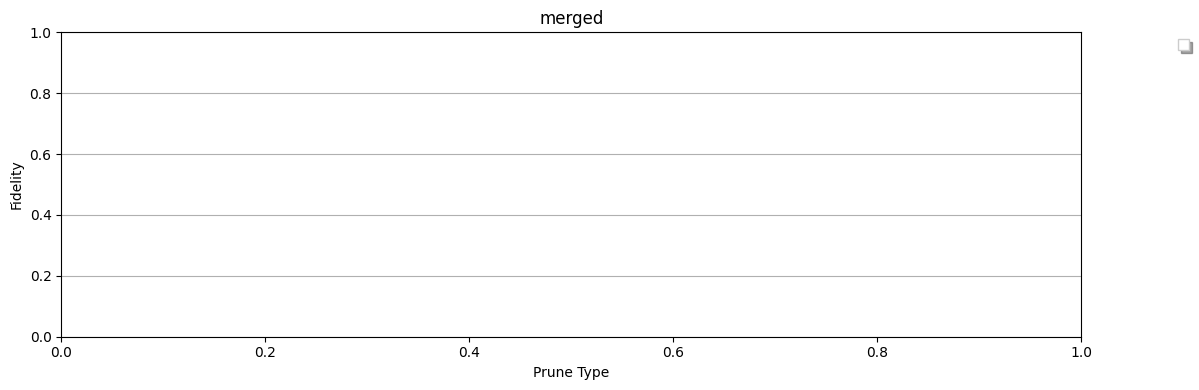

In [47]:
plot_whisker_cal(4, "merged", "ibm_kyiv")

#### With DD

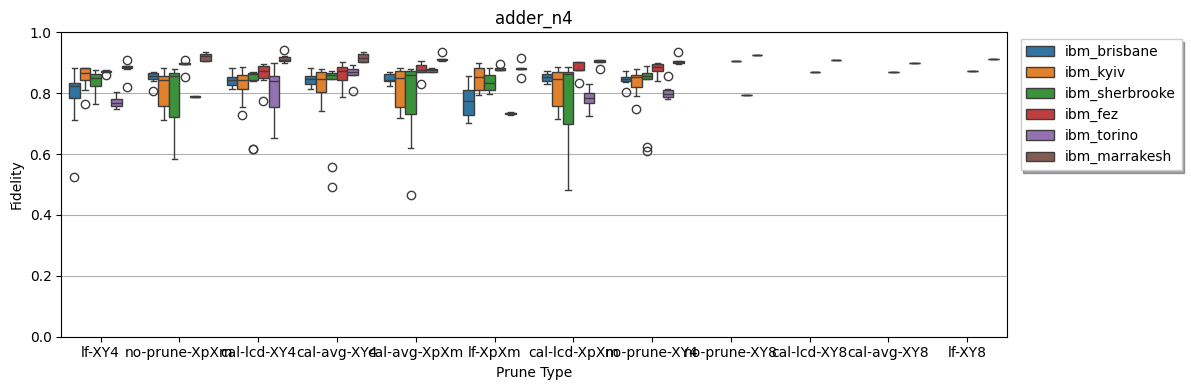

In [48]:
plot_whisker_cal(6, "adder_n4", "ibm_kyiv")

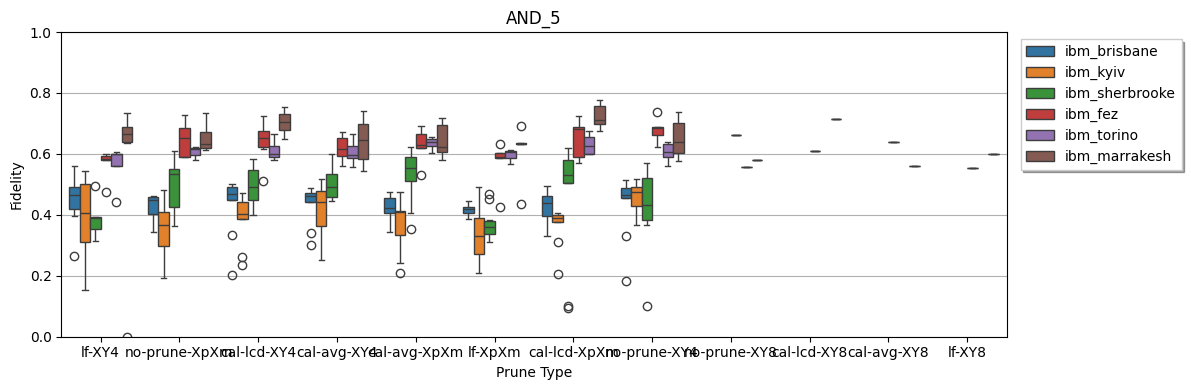

In [49]:
plot_whisker_cal(6, "AND_5", "ibm_kyiv")

### Summary Plot

In [65]:
def show_summary_bar_lines(df, opts, legends, circuits, ylim, ylabel, figsize=(12,5), 
                           width = 0.08, show_legend = True, legend_position = None, color_idx_add = 0,
                          file_name="", xlabel = None):
    fig, ax = plt.subplots(figsize=figsize)
    width = width
    x = np.arange(len(circuits))
    
    for i, opt in enumerate(opts):
        if i == 0:
            color_idx_add = 0
        else:
            color_idx_add = 0
            
        opt_data = df[df['prune_type'] == opt]
        # print(opt)
        # print(opt_data)
        # print(CB_color_cycle[i + color_idx_add], i + color_idx_add)
        rects = ax.bar(x + i * width, opt_data['mean'], yerr=opt_data['std'], 
                       color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2)
    
    ax.set_ylabel(ylabel)
    # ax.set_title('Mean Success rate with STD by Circuit and Opt')
    ax.set_xticks(x + width * (len(opts) - 1) / 2)
    ax.set_xticklabels(circuits)
    ax.grid(axis='y')
    if show_legend:
        if legend_position == None:
            ax.legend(legends, bbox_to_anchor=(1.01, 1))
        else:
            ax.legend(legends, loc = legend_position)
    else:
        ax.legend([])
    # ax.legend()

    if xlabel:
        plt.xlabel(xlabel)
        
    plt.ylim(ylim)
    # plt.savefig("./output/{}.png".format(file_name), dpi=700)
    plt.show()

In [66]:
def plot_summary_by_circuit_name(user_id, circuit_name, xlabel=None):
    df_cal = get_data_calibration(user_id, circuit_name)

    df_cal_summary = df_cal.groupby(['chip_name', 'hw_name', 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()

    hw_names = df_cal_summary['hw_name'].unique()
    
    opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4', 
            'lf-no-dd', 'lf-XpXm', 'lf-XY4', 
            'cal-avg-no-dd', 'cal-avg-XpXm', 'cal-avg-XY4', 
            'cal-lcd-no-dd', 'cal-lcd-XpXm', 'cal-lcd-XY4'
           ]
    legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4", 
               'LF', 'LF-XpXm', 'LF-XY4', 
               "Cal-Avg", "Cal-Avg-XpXm", "Cal-Avg-XY4",
               "Cal-Lcd", "Cal-Lcd-XpXm", "Cal-Lcd-XY4"
              ]

    show_summary_bar_lines(df_cal_summary, opts, legends, hw_names, [0,1], "Mean fidelity", (13,5), width=0.075, xlabel=xlabel)
    

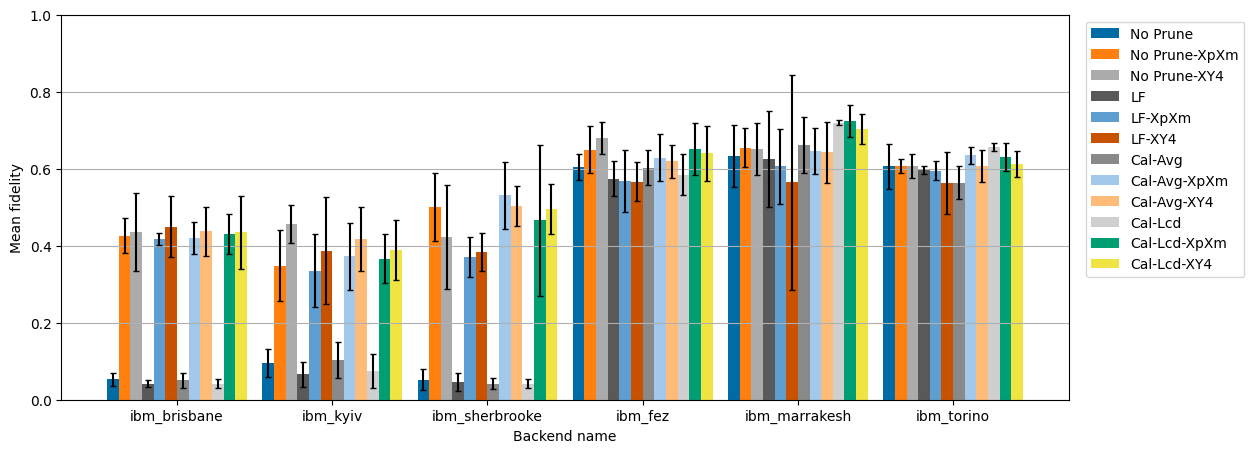

In [67]:
plot_summary_by_circuit_name("4,6", "AND_5", xlabel="Backend name")

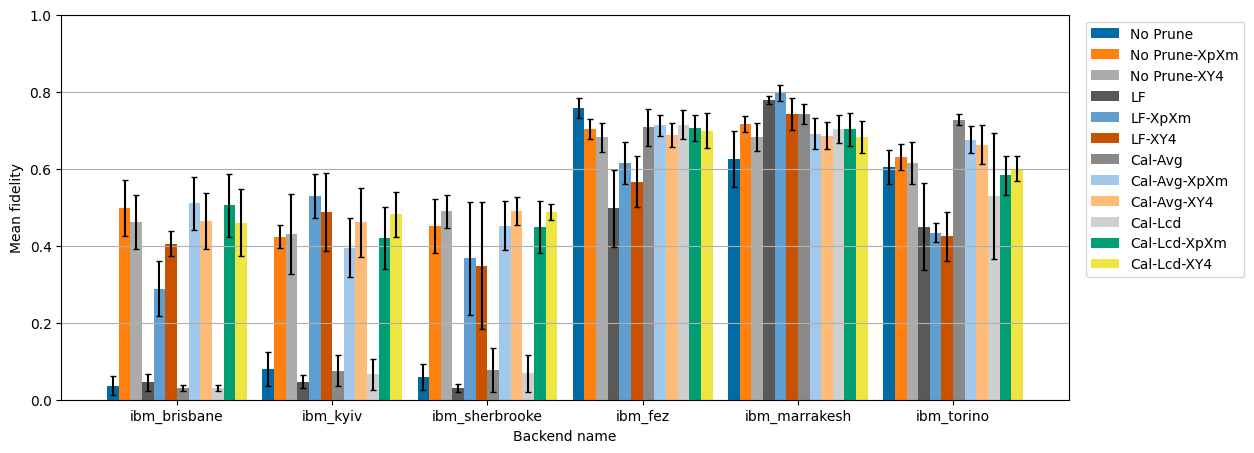

In [69]:
plot_summary_by_circuit_name("4,6", "OR_5", xlabel="Backend name")

#### Plot Normal by hw

In [74]:
def plot_summary_by_hw(user_id, hw_name, xlabel=None):
    df_cal_kyiv = get_data_calibration(user_id, hw_name=hw_name)

    df_cal_kyiv_summary = df_cal_kyiv.groupby(['mp_circuits', 'circuit_name', 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()

    circuits = df_cal_kyiv_summary['circuit_name'].unique()

    #opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4', 
    #        'lf-no-dd', 'lf-XpXm', 'lf-XY4', 
    #        'cal-avg-no-dd', 'cal-avg-XpXm', 'cal-avg-XY4', 
    #        'cal-lcd-no-dd', 'cal-lcd-XpXm', 'cal-lcd-XY4'
    #       ]
    #legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4", 
    #           'LF', 'LF-XpXm', 'LF-XY4', 
    #           "Cal-Avg", "Cal-Avg-XpXm", "Cal-Avg-XY4",
    #           "Cal-Lcd", "Cal-Lcd-XpXm", "Cal-Lcd-XY4"
    #          ]
    
    opts = ['no-prune-no-dd',
            'lf-no-dd',
            'cal-avg-no-dd',
            'cal-lcd-no-dd'
           ]
    legends = ["No Prune", 
               'LF', 
               "Cal-Avg", 
               "Cal-Lcd", 
              ]

    show_summary_bar_lines(df_cal_kyiv_summary, opts, legends, circuits, [0,1], "Mean fidelity", (8,5), width=0.2, xlabel=xlabel)
    
    

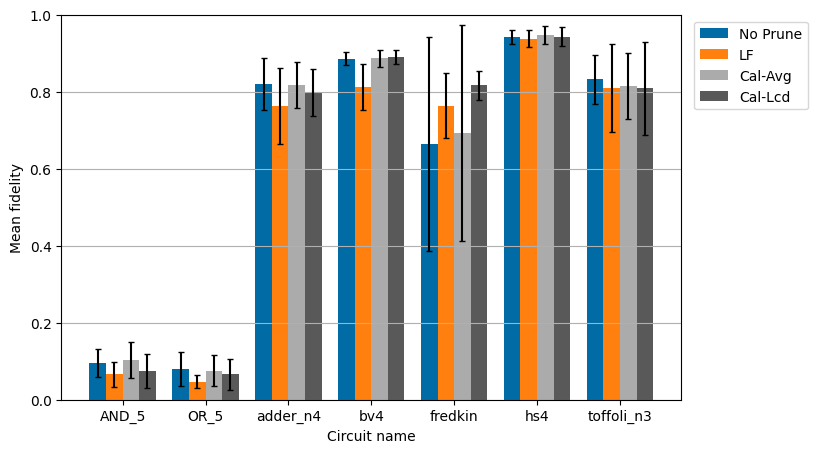

In [77]:
plot_summary_by_hw("4,6", "ibm_kyiv", xlabel="Circuit name")

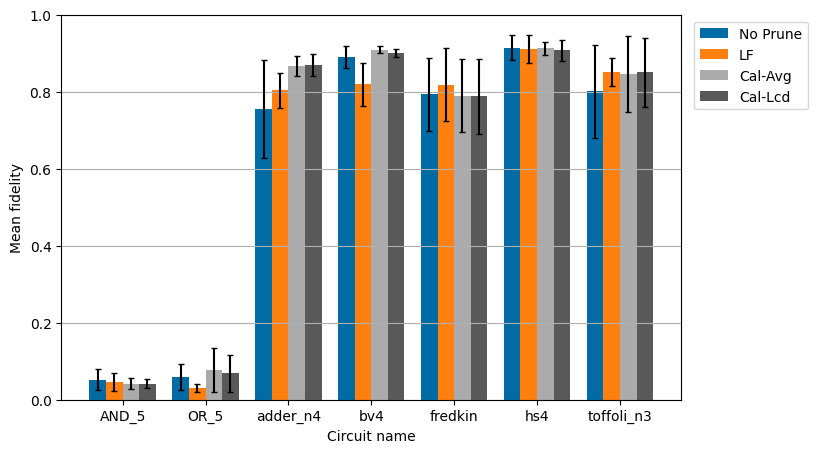

In [78]:
plot_summary_by_hw("4,6", "ibm_sherbrooke", xlabel="Circuit name")

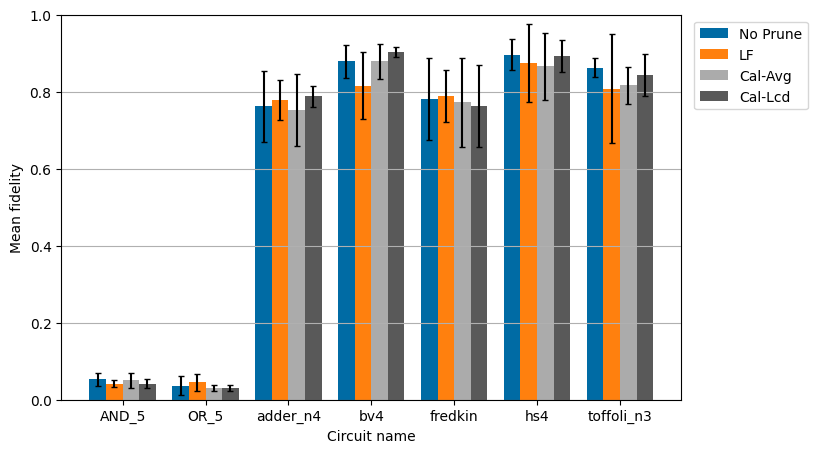

In [79]:
plot_summary_by_hw("4,6", "ibm_brisbane", xlabel="Circuit name")

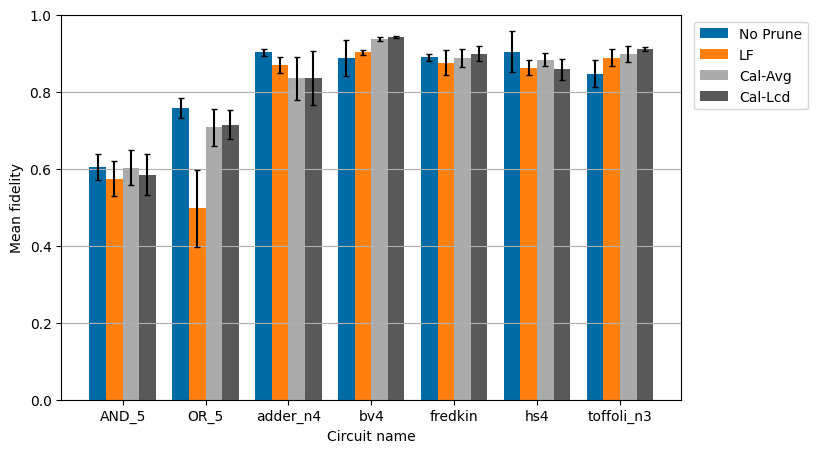

In [80]:
plot_summary_by_hw("4,6", "ibm_fez", xlabel="Circuit name")

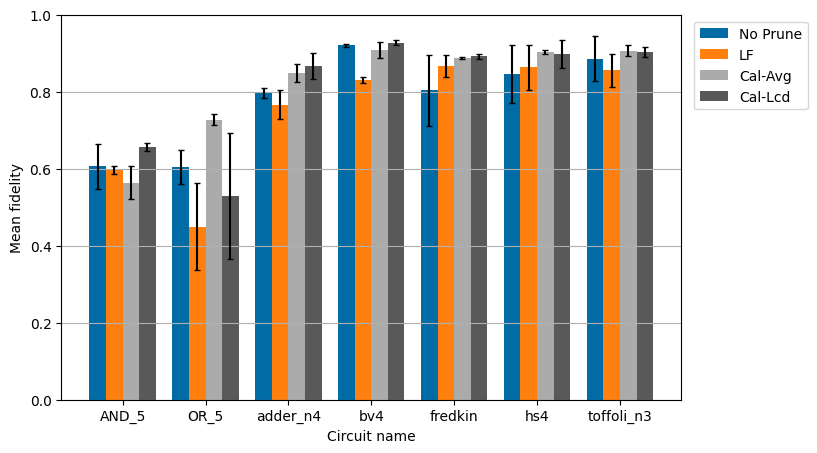

In [81]:
plot_summary_by_hw("4,6", "ibm_torino", xlabel="Circuit name")

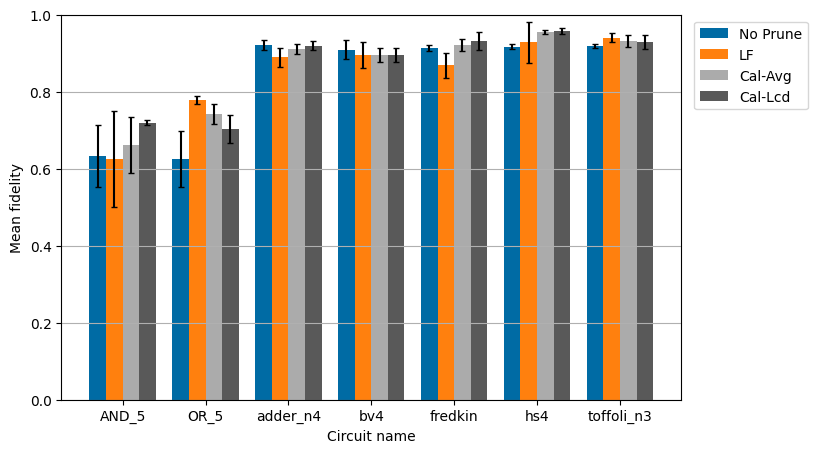

In [82]:
plot_summary_by_hw("4,6", "ibm_marrakesh", xlabel="Circuit name")

#### Plot DD Qiskit-3 by hw

In [84]:
def plot_summary_by_hw_dd(user_id, hw_name, xlabel=None):
    df_cal_kyiv = get_data_calibration(user_id, hw_name=hw_name)

    df_cal_kyiv_summary = df_cal_kyiv.groupby(['mp_circuits', 'circuit_name', 'prune_type'])['success_rate_tvd'].agg(['mean', 'std']).reset_index()

    circuits = df_cal_kyiv_summary['circuit_name'].unique()
    
    opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4'
           ]
    legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4"
              ]

    show_summary_bar_lines(df_cal_kyiv_summary, opts, legends, circuits, [0,1], "Mean fidelity", (8,5), width=0.2, xlabel=xlabel)

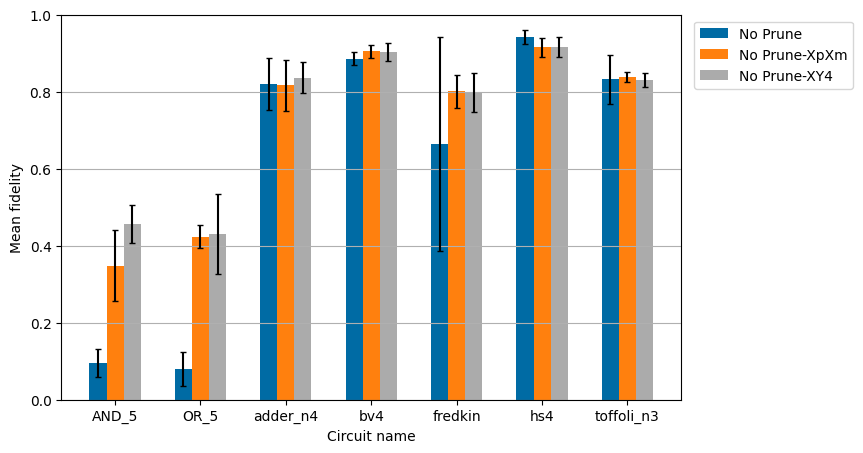

In [85]:
plot_summary_by_hw_dd("4,6", "ibm_kyiv", xlabel="Circuit name")

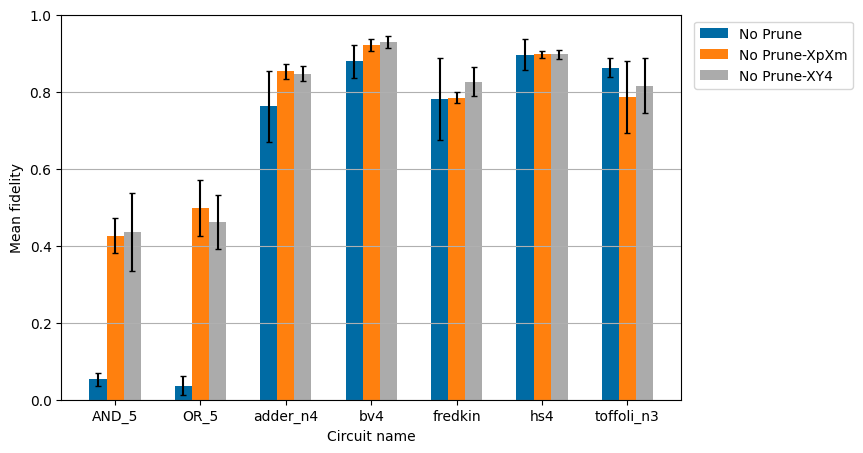

In [86]:
plot_summary_by_hw_dd("4,6", "ibm_brisbane", xlabel="Circuit name")

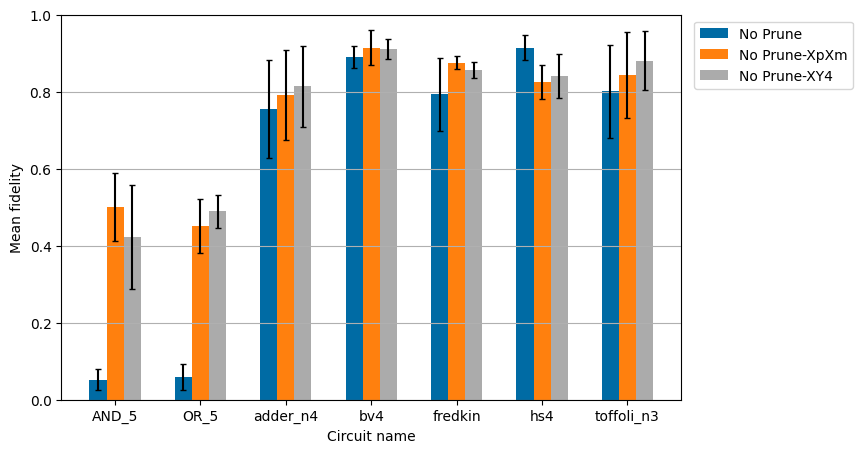

In [87]:
plot_summary_by_hw_dd("4,6", "ibm_sherbrooke", xlabel="Circuit name")

## State Preparation Polar Code

In [88]:
def get_data_polar(user_id, circuit_name, type="avg", hw_name="ibm_kyiv"):
    conn = mysql.connector.connect(**mysql_config)
    cursor = conn.cursor()

    if type == "avg":
        sql = f"""
SELECT CASE WHEN hw_name IN ("ibm_kyiv", "ibm_sherbrooke", "ibm_brisbane") THEN "Eagle" ELSE "Heron" END as chip_name,
hw_name, circuit_name, compilation_name, dd_sequence_type, COALESCE(mp_circuits, 0), 
CONCAT(prune_type, "-", dd_sequence_type) as prune_type, 
(total_shots), (polar_count_accept), (polar_count_accept) / (total_shots) * 100 as prep_rate
FROM(
SELECT hw_name, circuit_name, compilation_name, COALESCE(dd_sequence_type, "no-dd") as dd_sequence_type, 
COALESCE(mp_circuits, 0) as mp_circuits, 
COALESCE(prune_type, "no-prune") as prune_type, prune_parameters, CASE WHEN mp_circuits IS NULL THEN 0 ELSE 1 END as mp,  
(shots * COALESCE(mp_circuits,1)) as total_shots,  (polar_count_accept)
FROM framework.result WHERE user_id IN ({user_id}) AND status = "done" 
AND hw_name != "ibm_brisbane" AND circuit_name = "{circuit_name}") X
WHERE mp = 1 
ORDER BY hw_name; 
        """
    else:
        sql = f"""
    SELECT CASE WHEN hw_name IN ("ibm_kyiv", "ibm_sherbrooke", "ibm_brisbane") THEN "Eagle" ELSE "Heron" END as chip_name,
hw_name, circuit_name, compilation_name, dd_sequence_type, COALESCE(mp_circuits, 0), 
CONCAT(prune_type, "-", dd_sequence_type) as prune_type, 
(total_shots), (polar_count_accept), (polar_count_accept) / (total_shots) * 100 as prep_rate
FROM(
SELECT hw_name, circuit_name, compilation_name, COALESCE(dd_sequence_type, "no-dd") as dd_sequence_type, 
COALESCE(mp_circuits, 0) as mp_circuits, 
COALESCE(prune_type, "no-prune") as prune_type, prune_parameters, CASE WHEN mp_circuits IS NULL THEN 0 ELSE 1 END as mp,   
(shots ) as total_shots,  (polar_count_accept)
FROM framework.result WHERE user_id IN ({user_id}) AND status = "done" 
AND hw_name != "ibm_brisbane" AND circuit_name = "{circuit_name}") X
WHERE mp = 1 
ORDER BY hw_name; 
            """

     # insert to circuit
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()

    chip_name = []
    hw_name = []
    circuit_name = []
    compilation_name = []
    dd_sequence_type = []
    mp_circuits = []
    prune_type = []
    total_shots = []
    total_accept = []
    prep_rate = []
    
    for res in results:
        _chip_name, _hw_name, _circuit_name, _compilation_name, _dd_sequence_type, _mp_circuits, _prune_type, _total_shots, _total_accept, _prep_rate = res
    
        chip_name.append(_chip_name)
        hw_name.append(_hw_name)
        circuit_name.append(_circuit_name)
        compilation_name.append(_compilation_name)
        dd_sequence_type.append(_dd_sequence_type)
        mp_circuits.append(_mp_circuits)
        prune_type.append(_prune_type)
        total_shots.append(float(_total_shots))
        total_accept.append(float(_total_accept))
        prep_rate.append(float(_prep_rate))

    df = pd.DataFrame({
        'chip_name': chip_name,
        'hw_name': hw_name,
        'circuit_name': circuit_name,
        'compilation_name': compilation_name,
        'dd_sequence_type': dd_sequence_type,
        'mp_circuits': mp_circuits,
        'prune_type': prune_type,
        'total_shots': total_shots,
        'total_accept': total_accept,
        'prep_rate': prep_rate,
        })

    return df

In [102]:
def plot_polar_prep_rate(user_id, circuit_name, type, ylim, show_data="all", xlabel=None):
    df_polar = get_data_polar(user_id, circuit_name, type)
    df_polar_summary = df_polar.groupby(['chip_name', 'hw_name', 'prune_type'])['prep_rate'].agg(['mean', 'std']).reset_index()

    hw_names = df_polar_summary['hw_name'].unique()

    if show_data == "all":
        opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4', 
            'lf-no-dd', 'lf-XpXm', 'lf-XY4', 
            'cal-avg-no-dd', 'cal-avg-XpXm', 'cal-avg-XY4', 
            'cal-lcd-no-dd', 'cal-lcd-XpXm', 'cal-lcd-XY4'
           ]
        legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4", 
                   'LF', 'LF-XpXm', 'LF-XY4', 
                   "Cal-Avg", "Cal-Avg-XpXm", "Cal-Avg-XY4",
                   "Cal-Lcd", "Cal-Lcd-XpXm", "Cal-Lcd-XY4"
                  ]
    elif show_data == "prune":
        opts = ['no-prune-no-dd',
                'lf-no-dd', 
                'cal-avg-no-dd', 
                'cal-lcd-no-dd', 
               ]
        legends = ["No Prune", 
                   'LF', 
                   "Cal-Avg", 
                   "Cal-Lcd"
                  ]
    else:
        opts = ['no-prune-no-dd', 'no-prune-XpXm', 'no-prune-XY4'
           ]
        legends = ["No Prune", "No Prune-XpXm", "No Prune-XY4"
                  ]
        
    
    show_summary_bar_lines(df_polar_summary, opts, legends, hw_names, ylim, "Mean Prep Rate (avg)", (6,5), width=0.2, xlabel=xlabel)


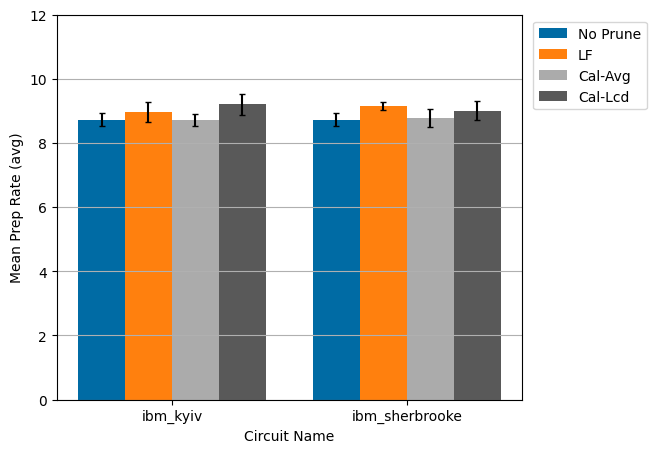

In [103]:
plot_polar_prep_rate("2,3,7", "polar_all_meas_n3_x", "avg", [0,12],show_data="prune", xlabel="Circuit Name")

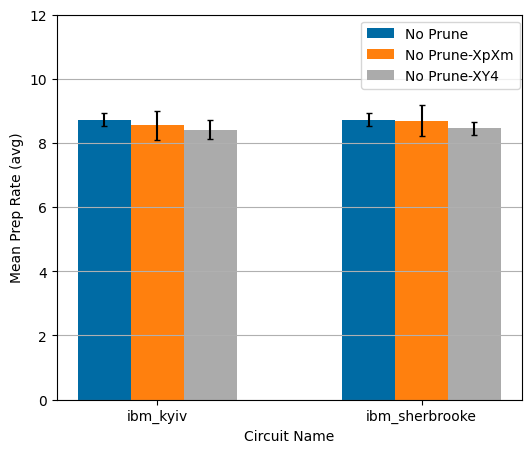

In [104]:
plot_polar_prep_rate("2,3,7", "polar_all_meas_n3_x", "avg", [0,12],show_data="dd", xlabel="Circuit Name")

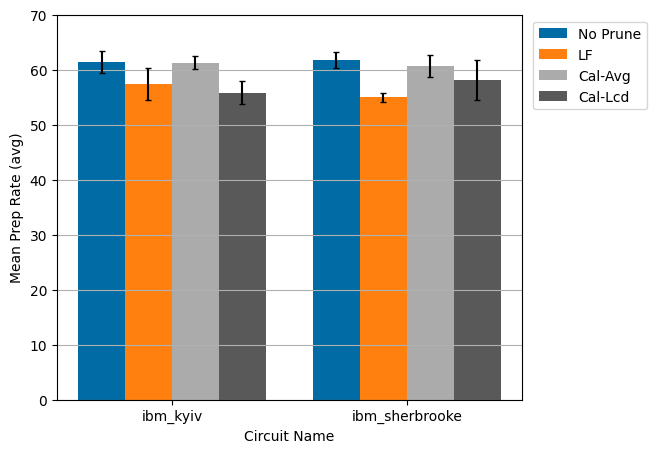

In [109]:
plot_polar_prep_rate("2,3,7", "polar_all_meas_n3_x", "all", [0,70],show_data="prune", xlabel="Circuit Name")

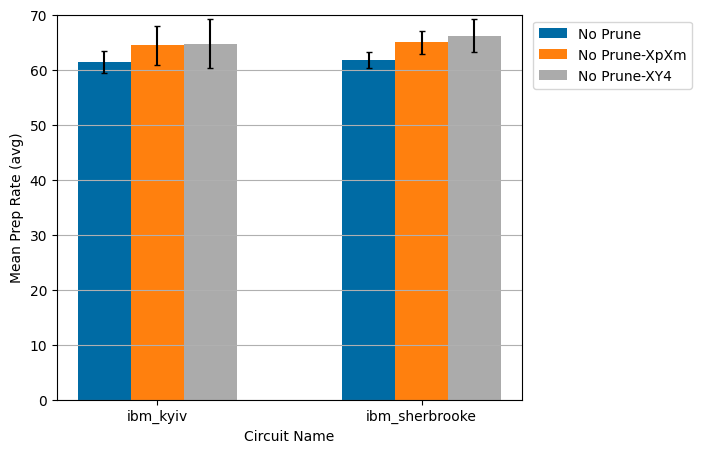

In [110]:
plot_polar_prep_rate("2,3,7", "polar_all_meas_n3_x", "all", [0,70],show_data="dd", xlabel="Circuit Name")